# Imports

In [1]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [2]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print(tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')

DEBUG - 2021-07-29 20:01:59,668 - retrain_ipynb - --=logging started=--


2.5.0
Running on CPU:arm


In [3]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyser.hyperparams 
analyser.hyperparams.__file__

Nemoware Analyser v2.4.5
USING WORKDIR: [/Users/artem/work/nemo/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/Users/artem/work/nemo/work/datasets]
reports_dir: [/Users/artem/work/nemo/work/reports]


/Users/artem/work/nemo/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


'/Users/artem/work/nemo/analyser/analyser/hyperparams.py'

### Prepare workdir

In [4]:
_work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /Users/artem/work/nemo/work


### Imports...

In [5]:
%matplotlib inline


import pandas as pd
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

from pathlib import Path
 

HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9629629629629629


### Query DB for contact IDs

In [6]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'])
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'])

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
except:
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(lastdate, export_fn)
stats

2021-07-29 16:52:14.151000 /Users/artem/work/nemo/work/contract_trainset_meta.temp.csv


,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len
60b7a55b061c76d77545505a,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,7.000000e+08,2021-07-29 08:56:09.177,2021-06-04 21:39:30.461,51064791f578e6b4ba62f717a09832db,2021-07-29 14:20:27.093368,NaN,20.366591,1218.0,False,RUB,4088.0
60b7a4cc061c76d7754546b0,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,4.285374e+08,2021-07-29 09:05:58.705,2021-06-03 06:10:15.320,1775ac8122d39314d9d8c7e8c0c03437,2021-07-29 14:20:25.189336,NaN,19.875888,563.0,NaN,RUB,774.0
60b7a5b1061c76d775455517,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,1.846700e+08,NaT,2021-06-05 16:36:09.054,50f010a37f21887b6d0242450c310cdb,2021-07-29 14:40:00.388647,NaN,19.034081,75.0,NaN,RUB,1062.0
60b7a5b1061c76d77545551e,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,2.969460e+07,NaT,2021-06-05 16:41:37.040,b14d88a9f8c9c698e7119e3c722267e2,2021-07-29 14:40:00.415121,NaN,17.206476,108.0,NaN,RUB,311.0
60b7a59a061c76d775455383,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,5.000000e+05,NaT,2021-06-05 10:03:03.705,2d78ec018ce5f8e710f0399e15a0f25f,2021-07-29 14:39:13.808920,NaN,13.122365,345.0,NaN,RUB,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60b7a595061c76d775455308,NaN,2.3.14,Газпромнефть-Каталитические системы,Измерительная техника,Заказчик,Исполнитель,Service,2.540000e+05,NaT,2021-06-05 08:14:43.166,21b3cefccb16f68f46eab84875555ad9,2021-07-29 14:38:53.843724,NaN,12.445093,277.0,NaN,RUB,4970.0
60b7a599061c76d775455369,NaN,2.3.14,Бизнес для бизнеса,Газпромнефть-Каталитические системы,Исполнитель,Заказчик,Service,1.200000e+05,NaT,2021-06-05 09:41:59.288,e91883d22724485a0f74c9961350acfa,2021-07-29 14:39:09.497453,NaN,11.695255,577.0,NaN,RUB,1370.0
60b7a5b5061c76d77545557a,NaN,2.3.14,Центр предпринимательских рисков,Газпромнефть-Каталитические системы,Исполнитель,Заказчик,Service,4.100000e+04,NaT,2021-06-05 18:15:41.276,d10b504216611046cb75a7b314568fcb,2021-07-29 14:40:16.223362,NaN,10.621352,1319.0,NaN,RUB,3527.0
60ebe82ecddbb3c487368c25,NaN,2.4.4,БДО Юникон,Газпром-нефть,Исполнитель,NaN,Service,NaN,NaT,2021-07-12 09:59:02.421,9afd3f4c0c6385de2e8fcc34cae08127,2021-07-29 14:40:18.736357,NaN,NaN,NaN,NaN,NaN,6045.0


## Fetch fresh docs from Mongo DB

In [7]:
query = {
  '$and': [
    {"parse.documentType": "CONTRACT"},
      
    {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}},
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
res = documents_collection.find(filter=query,
                                projection={'_id': True, 'user.updateDate':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(3000)

res = list([i for i in res])

_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

DB HOST IS: 192.168.10.36


/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)


#### Всего новых документов после 2021-07-29 16:52:14.151000 : 0

[]

In [8]:
from datetime import datetime
from math import log1p

from pandas import DataFrame

from analyser.persistence import DbJsonDoc
from trainsets.retrain_contract_uber_model import flatten_attributes_tree


def add_stats_record(d: DbJsonDoc, stats: DataFrame):
  _id = str(d.get_id())

  attr_map = flatten_attributes_tree(d.get_attributes_tree())

  # stats.at[_id, 'valid'] = True

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  if 'version' in d.analysis['attributes_tree']:
    stats.at[_id, 'version'] = '.'.join([str(x) for x in d.analysis['attributes_tree']['version']])
  else:
    stats.at[_id, 'version'] = d.analysis['version']

  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = d.analysis['analyze_timestamp']


  _value_tag = attr_map['sign_value_currency/value']
  if _value_tag:
    stats.at[_id, 'value'] = _value_tag['value']
    stats.at[_id, 'value_log1p'] = log1p(_value_tag['value'])
    stats.at[_id, 'value_span'] = _value_tag['span'][0]
    # find_in_dict('price.amount.span.0', d.get_attributes_tree())
    
  def _map_val(src, dest):
    if attr_map[src]:
        stats.at[_id, dest] = attr_map[src]['value']
        
  _map_val('sign_value_currency/currency', 'currency')
  _map_val('org-1-alias', 'org-1-alias')
  _map_val('org-2-alias', 'org-2-alias')
  _map_val('org-1-name', 'org-1-name')
  _map_val('org-2-name', 'org-2-name')
  _map_val('subject', 'subject')
 


  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = d.user[
      'updateDate']  # find_in_dict('attributes_tree.creation_date', d.user)


In [9]:
# res[:4]
# from tqdm import tqdm

docs_ids = [i["_id"] for i in res]   
# stats = DataFrame()
    

for k, oid in enumerate(docs_ids):
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
    
    add_stats_record(jd, stats)
    
    if k % 20 == 0:
        print(k)
        stats.to_csv(export_fn, index=True)
    
stats.to_csv(export_fn, index=True)
stats

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len
60b7a55b061c76d77545505a,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,7.000000e+08,2021-07-29 08:56:09.177,2021-06-04 21:39:30.461,51064791f578e6b4ba62f717a09832db,2021-07-29 14:20:27.093368,NaN,20.366591,1218.0,False,RUB,4088.0
60b7a4cc061c76d7754546b0,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,4.285374e+08,2021-07-29 09:05:58.705,2021-06-03 06:10:15.320,1775ac8122d39314d9d8c7e8c0c03437,2021-07-29 14:20:25.189336,NaN,19.875888,563.0,NaN,RUB,774.0
60b7a5b1061c76d775455517,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,1.846700e+08,NaT,2021-06-05 16:36:09.054,50f010a37f21887b6d0242450c310cdb,2021-07-29 14:40:00.388647,NaN,19.034081,75.0,NaN,RUB,1062.0
60b7a5b1061c76d77545551e,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,2.969460e+07,NaT,2021-06-05 16:41:37.040,b14d88a9f8c9c698e7119e3c722267e2,2021-07-29 14:40:00.415121,NaN,17.206476,108.0,NaN,RUB,311.0
60b7a59a061c76d775455383,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,5.000000e+05,NaT,2021-06-05 10:03:03.705,2d78ec018ce5f8e710f0399e15a0f25f,2021-07-29 14:39:13.808920,NaN,13.122365,345.0,NaN,RUB,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60b7a595061c76d775455308,NaN,2.3.14,Газпромнефть-Каталитические системы,Измерительная техника,Заказчик,Исполнитель,Service,2.540000e+05,NaT,2021-06-05 08:14:43.166,21b3cefccb16f68f46eab84875555ad9,2021-07-29 14:38:53.843724,NaN,12.445093,277.0,NaN,RUB,4970.0
60b7a599061c76d775455369,NaN,2.3.14,Бизнес для бизнеса,Газпромнефть-Каталитические системы,Исполнитель,Заказчик,Service,1.200000e+05,NaT,2021-06-05 09:41:59.288,e91883d22724485a0f74c9961350acfa,2021-07-29 14:39:09.497453,NaN,11.695255,577.0,NaN,RUB,1370.0
60b7a5b5061c76d77545557a,NaN,2.3.14,Центр предпринимательских рисков,Газпромнефть-Каталитические системы,Исполнитель,Заказчик,Service,4.100000e+04,NaT,2021-06-05 18:15:41.276,d10b504216611046cb75a7b314568fcb,2021-07-29 14:40:16.223362,NaN,10.621352,1319.0,NaN,RUB,3527.0
60ebe82ecddbb3c487368c25,NaN,2.4.4,БДО Юникон,Газпром-нефть,Исполнитель,NaN,Service,NaN,NaT,2021-07-12 09:59:02.421,9afd3f4c0c6385de2e8fcc34cae08127,2021-07-29 14:40:18.736357,NaN,NaN,NaN,NaN,NaN,6045.0


In [10]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len
60b7a55b061c76d77545505a,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,7.000000e+08,2021-07-29 08:56:09.177,2021-06-04 21:39:30.461,51064791f578e6b4ba62f717a09832db,2021-07-29 14:20:27.093368,NaN,20.366591,1218.0,False,RUB,4088.0
60b7a4cc061c76d7754546b0,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,4.285374e+08,2021-07-29 09:05:58.705,2021-06-03 06:10:15.320,1775ac8122d39314d9d8c7e8c0c03437,2021-07-29 14:20:25.189336,NaN,19.875888,563.0,NaN,RUB,774.0
60b7a5b1061c76d775455517,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,1.846700e+08,NaT,2021-06-05 16:36:09.054,50f010a37f21887b6d0242450c310cdb,2021-07-29 14:40:00.388647,NaN,19.034081,75.0,NaN,RUB,1062.0
60b7a5b1061c76d77545551e,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,2.969460e+07,NaT,2021-06-05 16:41:37.040,b14d88a9f8c9c698e7119e3c722267e2,2021-07-29 14:40:00.415121,NaN,17.206476,108.0,NaN,RUB,311.0
60b7a59a061c76d775455383,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,5.000000e+05,NaT,2021-06-05 10:03:03.705,2d78ec018ce5f8e710f0399e15a0f25f,2021-07-29 14:39:13.808920,NaN,13.122365,345.0,NaN,RUB,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60b7a595061c76d775455308,NaN,2.3.14,газпромнефть-каталитические системы,измерительная техника,заказчик,исполнитель,Service,2.540000e+05,NaT,2021-06-05 08:14:43.166,21b3cefccb16f68f46eab84875555ad9,2021-07-29 14:38:53.843724,NaN,12.445093,277.0,NaN,RUB,4970.0
60b7a599061c76d775455369,NaN,2.3.14,бизнес для бизнеса,газпромнефть-каталитические системы,исполнитель,заказчик,Service,1.200000e+05,NaT,2021-06-05 09:41:59.288,e91883d22724485a0f74c9961350acfa,2021-07-29 14:39:09.497453,NaN,11.695255,577.0,NaN,RUB,1370.0
60b7a5b5061c76d77545557a,NaN,2.3.14,центр предпринимательских рисков,газпромнефть-каталитические системы,исполнитель,заказчик,Service,4.100000e+04,NaT,2021-06-05 18:15:41.276,d10b504216611046cb75a7b314568fcb,2021-07-29 14:40:16.223362,NaN,10.621352,1319.0,NaN,RUB,3527.0
60ebe82ecddbb3c487368c25,NaN,2.4.4,бдо юникон,газпром-нефть,исполнитель,NaN,Service,NaN,NaT,2021-07-12 09:59:02.421,9afd3f4c0c6385de2e8fcc34cae08127,2021-07-29 14:40:18.736357,NaN,NaN,NaN,NaN,NaN,6045.0


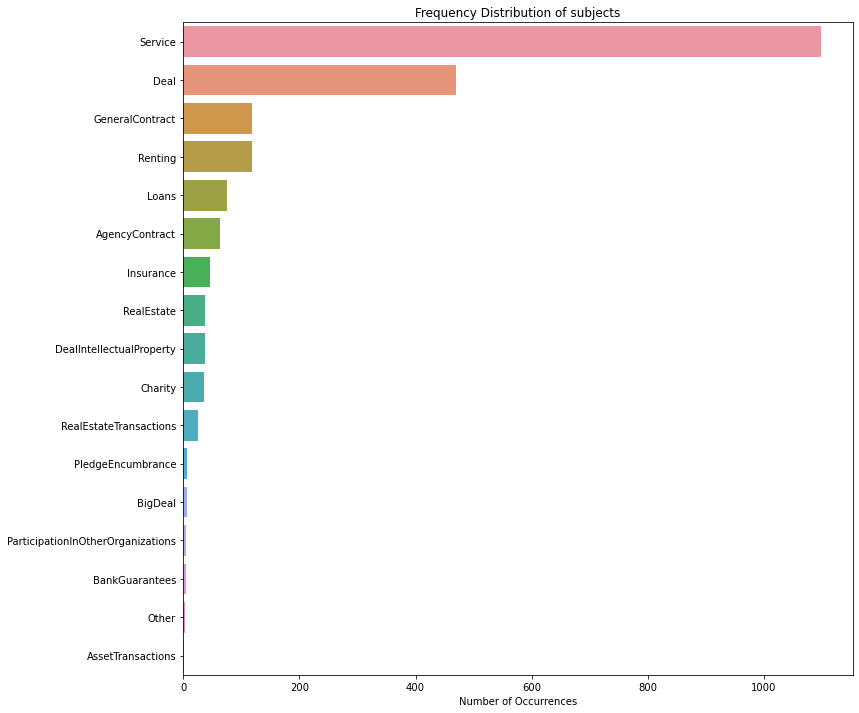

In [11]:
%matplotlib inline

cnt = stats2['subject'].value_counts()
# alias_count = stats2['org-1-alias'].value_counts()

#plot distribution---------------------
plt.figure(figsize=(12, 12))
sns.barplot(x=cnt.values, y=cnt.index)

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()

In [12]:
stats2['subject'].value_counts()

Service                              1098
Deal                                  469
GeneralContract                       119
Renting                               119
Loans                                  75
AgencyContract                         64
Insurance                              46
RealEstate                             38
DealIntellectualProperty               37
Charity                                36
RealEstateTransactions                 25
PledgeEncumbrance                       6
BigDeal                                 6
ParticipationInOtherOrganizations       4
BankGuarantees                          4
Other                                   3
AssetTransactions                       1
Name: subject, dtype: int64

In [13]:
stats2['org-1-alias'].value_counts()

заказчик                   681
исполнитель                472
покупатель                 323
продавец                    89
поставщик                   82
                          ... 
управляемая организация      1
субсубарендатор              1
нск                          1
благополучатель              1
-                            1
Name: org-1-alias, Length: 69, dtype: int64

In [14]:
stats2['org-2-alias'].value_counts()

исполнитель         552
заказчик            507
поставщик           282
покупатель          172
подрядчик           129
                   ... 
весна                 1
субподрядчик          1
инвестором            1
налогоплательщик      1
компания              1
Name: org-2-alias, Length: 65, dtype: int64

In [15]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val > 0:
                stats2.at[i, score_column_name] *= log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        
            
def calc_column_val_importance(stats2, column_name):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            a_weight = counts[val]
            stats2.at[i, score_column_name] *= 1./log1p(a_weight)
        else:
            stats2.at[i, score_column_name] *= 2.0

for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'
    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.


calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 4.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

calc_column_val_importance(stats2, 'org-1-name')
calc_column_val_importance(stats2, 'org-2-name')
calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject')


# calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=False)
# 



sub = stats2[['url','version','len', 'org-1-name', 'org-2-name', 'org-1-alias', 'org-2-alias', 'subject', 'value', 'user_correction_date']]
sub.to_csv(Path(work_dir) / 'contract_trainset_meta.hp.csv', index=True)
sub

,url,version,len,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date
5fc7a033c54bc33809e261a3,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,2.3.14,6900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT
5fb3b9aa00881c332b56744b,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,8405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT
5fb3b99200881c332b56739b,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,4542.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT
5fb3b99300881c332b5673aa,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,15737.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT
5fb3b99500881c332b5673bd,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,15984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...
5fbbe468a2b4551c06107b3a,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,2.3.14,2583.0,арктика медиа,тв-новости,заказчик,исполнитель,Service,NaN,2020-11-24 08:35:13.549
5fdb2143542ce403c92b45ae,http://gpn-audit.nemosoft.ru/#/audit/edit/5fdb...,2.3.14,3406.0,рекламно-информационное агентство «город»,вторичный ресурс,заказчик,исполнитель,Service,NaN,2020-12-17 11:46:13.192
5fbbe46ca2b4551c06107c08,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,2.3.14,4110.0,арктика медиа,софтлайн трейд,покупатель,поставщик,Deal,NaN,2020-11-24 09:48:00.584
60b7a4c2061c76d7754545c4,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,1938.0,газпромнефть-каталитические системы,газпромнефть-снабжение,заказчик,исполнитель,Service,NaN,2021-06-22 09:17:31.134


## Find duplicates

In [16]:
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len,unseen,score
5fb3b9b000881c332b56746c,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-11-17 11:55:01.865,52a9649ba88d76e1f943d31db634dff4,2021-07-29 14:27:33.322139,NaN,NaN,NaN,NaN,NaN,49346.0,True,92160.000000
5fc7a047c54bc33809e26372,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,2.3.14,газпромнефть-оренбург,ноябрьскнефтегазсвязь,заказчик,NaN,Service,90619807.0,NaT,2020-12-03 08:07:48.699,82137d4b0ded9b81b1d12f4d9e98c383,2021-07-29 14:32:11.482145,NaN,18.322183,4503.0,NaN,RUB,49341.0,True,0.456324
5fca2acd9083b679224c77da,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,2.3.14,газпромнефть-оренбург,ноябрьскнефтегазсвязь,заказчик,подрядчик,GeneralContract,108743768.0,2020-12-10 10:40:23.060,2020-12-10 10:40:36.652,6b64d52e5ecb4941696164ed4950e735,2021-07-29 14:22:29.241766,NaN,18.504505,4250.0,NaN,RUB,49045.0,False,0.008655
5fb3b9a800881c332b567433,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-11-17 11:54:59.086,287d93101b752b5f041d476d7196864e,2021-07-29 14:27:25.900821,NaN,NaN,NaN,NaN,NaN,44188.0,True,92160.000000
5fc7a044c54bc33809e2634d,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-12-02 14:13:46.114,2be147450a483219b8d7139324d23b03,2021-07-29 14:32:01.545688,NaN,NaN,NaN,NaN,NaN,44185.0,True,92160.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60b7a5b1061c76d775455521,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,NaN,NaT,2021-06-05 16:41:48.457,b1a3985249b51612f7ac074d2966d2b6,2021-07-29 14:40:00.437010,NaN,NaN,NaN,NaN,NaN,198.0,True,1645.207572
60b7a4f6061c76d7754549e4,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,NaN,NaT,2021-06-03 23:10:28.433,c37abb17ae9e5c8ba15d4ffa2ada51b0,2021-07-29 14:35:11.021034,NaN,NaN,NaN,NaN,NaN,91.0,True,1645.207572
60b7a502061c76d775454acf,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,NaN,NaT,2021-06-04 02:16:34.669,0e4c83130e2fa3bda54cdec67dd53694,2021-07-29 14:35:31.486684,NaN,NaN,NaN,NaN,NaN,81.0,True,1645.207572
60b7a58e061c76d77545525d,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,NaN,NaT,2021-06-05 06:12:14.896,16919b50a8bbeca754edbb08c5636bb5,2021-07-29 14:38:30.637880,NaN,NaN,NaN,NaN,NaN,25.0,True,1872.338776


In [17]:
for i, row in stats2.iterrows():   
#     print(row['org-1-name'])

    _str = ':'.join(    sorted( [str(x) for x in [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'], row['value'], row['subject']]] ) )
#     print(hash( _str  ), _str)
    stats2.at[i, 'hash'] = hash( _str  )
stats2.sort_values(['hash'])

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,...,export_date,subject confidence,value_log1p,value_span,valid,currency,len,unseen,score,hash
5fb6750933c72547b75500f1,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,2.3.14,арктика медиа,NaN,исполнитель,NaN,Service,NaN,NaT,2020-11-19 14:22:33.220,...,2021-07-29 14:29:38.366478,NaN,NaN,NaN,NaN,NaN,2296.0,True,1.756880,-9.206072e+18
5fbbbd1ca2b4551c06107a53,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,2.3.14,арктика медиа,NaN,исполнитель,NaN,Service,NaN,NaT,2020-11-23 14:14:09.686,...,2021-07-29 14:30:44.327419,NaN,NaN,NaN,NaN,NaN,2296.0,True,1.756880,-9.206072e+18
60b7a4eb061c76d7754548ee,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-каталитические системы,эскон,покупатель,поставщик,Deal,NaN,NaT,2021-06-03 19:37:19.850,...,2021-07-29 14:34:43.552563,NaN,NaN,NaN,NaN,NaN,14801.0,True,0.015914,-9.204316e+18
60b7a4dd061c76d77545482f,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,газпромнефть-каталитические системы,архитектурно-проектная мастерская «стеле»-2010,заказчик,исполнитель,Service,50000.0,NaT,2021-06-03 16:32:59.319,...,2021-07-29 14:34:13.655462,NaN,10.819798,4766.0,NaN,RUB,7758.0,True,0.037983,-9.203922e+18
60b7a4f6061c76d7754549f6,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,меретояханефтегаз,газпромнефть-гео,владелец лицензии,оператор,Service,NaN,NaT,2021-06-03 23:20:10.406,...,2021-07-29 14:35:14.493529,NaN,NaN,NaN,NaN,NaN,2576.0,True,0.193503,-9.199259e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fdb2145542ce403c92b45ed,http://gpn-audit.nemosoft.ru/#/audit/edit/5fdb...,2.3.14,рекламно-информационное агентство «город»,солнце,исполнитель,заказчик,Service,NaN,NaT,2020-12-17 15:06:40.939,...,2021-07-29 14:32:29.851000,NaN,NaN,NaN,NaN,NaN,2554.0,True,0.007110,9.205171e+18
5fbbe467a2b4551c06107afa,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,2.3.14,арктика медиа,аллегро м,заказчик,исполнитель,Service,NaN,NaT,2020-11-23 16:43:58.359,...,2021-07-29 14:30:51.832105,NaN,NaN,NaN,NaN,NaN,2849.0,True,0.006106,9.211876e+18
5fbbbd14a2b4551c06107902,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,2.3.14,арктика медиа,аллегро м,заказчик,исполнитель,Service,NaN,NaT,2020-11-23 14:12:40.518,...,2021-07-29 14:30:10.859593,NaN,NaN,NaN,NaN,NaN,2849.0,True,0.006106,9.211876e+18
5fbbad2ca2b4551c06107851,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,2.3.14,арктика медиа,аллегро м,заказчик,исполнитель,Service,NaN,NaT,2020-11-23 13:00:49.179,...,2021-07-29 14:29:55.628718,NaN,NaN,NaN,NaN,NaN,2849.0,True,0.006106,9.211876e+18


In [18]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

dups[40:].head(40)

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,...,subject confidence,value_log1p,value_span,valid,currency,len,unseen,score,hash,dups
5fbbad2ba2b4551c0610783a,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,2.3.14,арктика медиа,днс ритейл,покупатель,поставщик,Deal,NaN,NaT,2020-11-23 12:50:06.908,...,NaN,NaN,NaN,NaN,NaN,1896.0,True,0.006828,7.612768e+18,4.0
5fb27c5fd8c9df1ed1236e8f,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb2...,2.3.14,арктика медиа,новамедиаком,исполнитель,заказчик,Service,NaN,NaT,2020-11-16 16:37:53.388,...,NaN,NaN,NaN,NaN,NaN,2402.0,True,0.003801,6.744609e+18,4.0
5fb6750833c72547b75500cc,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,2.3.14,арктика медиа,новамедиаком,исполнитель,заказчик,Service,NaN,NaT,2020-11-19 14:15:38.282,...,NaN,NaN,NaN,NaN,NaN,2402.0,True,0.003801,6.744609e+18,4.0
5fbbe46aa2b4551c06107b9e,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,2.3.14,арктика медиа,новамедиаком,исполнитель,заказчик,Service,NaN,NaT,2020-11-23 16:58:20.018,...,NaN,NaN,NaN,NaN,NaN,2402.0,True,0.003801,6.744609e+18,4.0
5fbbbd18a2b4551c06107980,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,2.3.14,арктика медиа,новамедиаком,исполнитель,заказчик,Service,NaN,NaT,2020-11-23 14:13:16.489,...,NaN,NaN,NaN,NaN,NaN,2402.0,True,0.003801,6.744609e+18,4.0
5fbbbd16a2b4551c06107948,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,2.3.14,мантульников кирилл олегович,"арктик^ медиа""",исполнитель,заказчик,NaN,NaN,NaT,2020-11-23 13:57:24.376,...,NaN,NaN,NaN,NaN,NaN,1881.0,True,1.609656,6.207887e+18,4.0
5fb6750733c72547b75500ba,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,2.3.14,мантульников кирилл олегович,"арктик^ медиа""",исполнитель,заказчик,NaN,NaN,NaT,2020-11-19 13:42:06.486,...,NaN,NaN,NaN,NaN,NaN,1881.0,True,1.609656,6.207887e+18,4.0
5fbbe46ca2b4551c06107c07,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,2.3.14,мантульников кирилл олегович,"арктик^ медиа""",исполнитель,заказчик,NaN,NaN,NaT,2020-11-23 16:38:13.505,...,NaN,NaN,NaN,NaN,NaN,1881.0,True,1.609656,6.207887e+18,4.0
5fb27c62d8c9df1ed1236efc,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb2...,2.3.14,мантульников кирилл олегович,"арктик^ медиа""",исполнитель,заказчик,NaN,NaN,NaT,2020-11-16 16:07:21.198,...,NaN,NaN,NaN,NaN,NaN,1881.0,True,1.609656,6.207887e+18,4.0
5fb3d7a178df3635f5441d5e,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,газпромнефть-ннг,издательскополиграфическое предприятие «мастер...,заказчик,исполнитель,NaN,NaN,NaT,2020-11-17 15:21:45.771,...,NaN,NaN,NaN,NaN,NaN,2307.0,True,0.290356,5.610698e+18,4.0


In [19]:
unks

 3.192460e+18    5
 8.446801e+18    5
-2.636118e+18    5
 2.104737e+18    5
 9.007717e+17    5
                ..
 7.405055e+18    1
-1.260256e+18    1
-2.979829e+18    1
-6.129728e+18    1
-2.448766e+18    1
Name: hash, Length: 2086, dtype: int64

In [20]:
dups_s = dups.sort_values([score_column_name], ascending=False).copy()
dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.hp.csv', index=True)
dups_s

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,...,subject confidence,value_log1p,value_span,valid,currency,len,unseen,score,hash,dups
5fb3d49c78df3635f5441b62,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-11-17 13:49:00.352,...,NaN,NaN,NaN,NaN,NaN,2294.0,True,92160.000000,4.775246e+18,2.0
5fb3d79c78df3635f5441cfd,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-11-17 15:21:39.153,...,NaN,NaN,NaN,NaN,NaN,8397.0,True,92160.000000,-6.373927e+18,2.0
5fb376e0d8c9df1ed123721c,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-11-17 07:09:53.194,...,NaN,NaN,NaN,NaN,NaN,261.0,True,92160.000000,2.014607e+18,2.0
60a22cf694cd51a9e6313a95,http://gpn-audit.nemosoft.ru/#/audit/edit/60a2...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2021-05-17 11:45:35.828,...,NaN,NaN,NaN,NaN,NaN,1787.0,True,92160.000000,-3.657411e+18,1.0
5fb376e2d8c9df1ed1237279,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaT,2020-11-17 07:11:54.477,...,NaN,NaN,NaN,NaN,NaN,314.0,True,92160.000000,6.182671e+18,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fe48217b770574a005555a4,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,2.3.14,издательско-полиграфическое предприятие «масте...,захаров александр станиславович,заказчик,исполнитель,Service,NaN,2021-07-28 11:06:25.700,2020-12-24 15:55:58.482,...,NaN,NaN,NaN,NaN,NaN,1291.0,False,0.001472,-1.222760e+18,1.0
5fe4821bb770574a0055565d,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,2.3.14,издательско-полиграфическое предприятие «масте...,захаров александр станиславович,заказчик,исполнитель,Service,NaN,2020-12-25 08:23:17.164,2020-12-24 16:58:20.203,...,NaN,NaN,NaN,NaN,NaN,1280.0,False,0.001472,6.977269e+18,1.0
5fe4821fb770574a0055575a,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,2.3.13,издательско-полиграфическое предприятие «масте...,сувенир-медиа т,заказчик,поставщик,Service,NaN,2021-07-22 08:40:44.990,2020-12-24 17:53:40.209,...,NaN,NaN,NaN,NaN,NaN,1616.0,False,0.001378,-3.719833e+18,1.0
5fdb2143542ce403c92b45ae,http://gpn-audit.nemosoft.ru/#/audit/edit/5fdb...,2.3.14,рекламно-информационное агентство «город»,вторичный ресурс,заказчик,исполнитель,Service,NaN,2020-12-17 11:46:13.192,2020-12-17 16:29:43.176,...,NaN,NaN,NaN,NaN,NaN,3406.0,False,0.001189,-2.970515e+18,1.0
